Non-commercial Use License

Copyright (c) 2021 Siemens Technology

This software, along with associated documentation files (the "Software"), is 
provided for the sole purpose of providing Proof of Concept. Any commercial 
uses of the Software including, but not limited to, the rights to sublicense, 
and/or sell copies of the Software are prohibited and are subject to a 
separate licensing agreement with Siemens. This software may be proprietary 
to Siemens and may be covered by patent and copyright laws. Processes 
controlled by the Software are patent pending.

The above copyright notice and this permission notice shall remain attached 
to the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE 
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import os, sys
THIS_DIR = os.path.abspath('')

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from matplotlib import rc
# rc('text', usetex=True)
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

# local application imports
# from trainer import Model

seed_everything(0)
%matplotlib inline
DPI = 600
FIG_DIR = os.path.join(THIS_DIR, "figures")

In [2]:
system_names = [
  "ER50k50",
  "ER100k50",
  "ER200k50"
]
model_names = [
  "CLNNwC_IP",
  "CLNN_CD_MLP",
  "CLNN_IN",
  "IN"
]
short_system_names = system_names
formal_model_names = [
  "CM-CD-CLNN",
  "MLP-CD-CLNN",
  "IN-CP-CLNN",
  "IN-SP-CP"
]

In [3]:
import pickle
logs = {}
for system in system_names:
    logs[system] = {}
    for model in model_names:
        with open(model+'_'+system, 'rb') as handle:
            logs[system][model] = pickle.load(handle)

In [4]:
# plot test error
def cal_b(t=5):
    b = {}
    b_err = {}
    for model in model_names:
        b[model] = np.zeros(len(system_names))
        b_err[model] = np.zeros(len(system_names))
    for model in model_names:
        for system_idx in range(len(system_names)):
            seq = logs[system_names[system_idx]][model]['rel_err'].numpy()[:, 0:t].sum(1)
            m, se = seq.mean(), scipy.stats.sem(seq)
            b[model][system_idx] = m
            b_err[model][system_idx] = se * scipy.stats.t.ppf((1 + 0.95) / 2., len(seq)-1)
    return b, b_err
b, b_err = cal_b()

In [5]:
c_palette = ['#fdae6b', '#cbc9e2', '#9e9ac8', '#6a51a3']

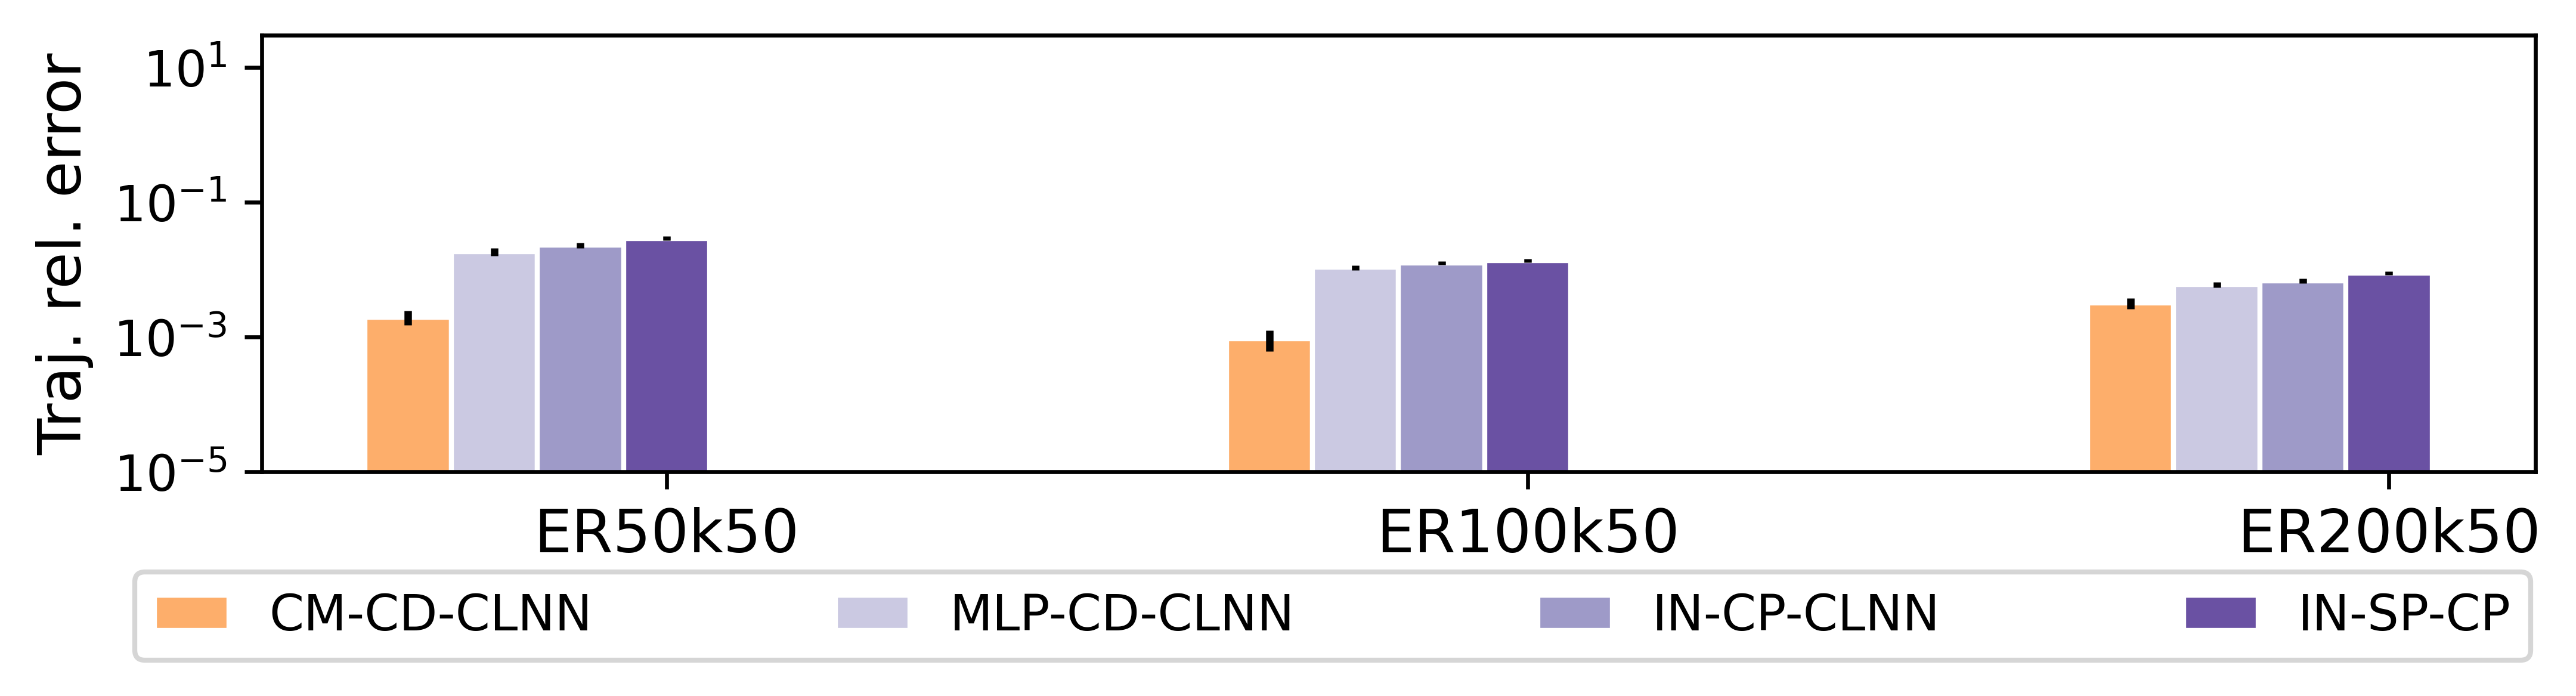

In [6]:
fig, ax = plt.subplots(figsize=(8.2, 2.0), dpi=DPI)

barWidth = 0.1
p_x = []
p_x.append(np.arange(len(system_names)))
for i in range(1, len(model_names)):
    p_x.append([x+barWidth for x in p_x[i-1]])

for i in range(len(model_names)):
    plt.bar(p_x[i], b[model_names[i]], yerr=b_err[model_names[i]], width=barWidth, color=c_palette[i], edgecolor='white', label=formal_model_names[i])
plt.yscale('log')
plt.ylim(0.00001, 30)
plt.xticks([r + 3*barWidth for r in range(len(system_names))], short_system_names, fontsize=12)
plt.ylabel('Traj. rel. error', fontsize=12)

# create legend 
fig.subplots_adjust(bottom=0.27)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels=labels, 
           bbox_to_anchor=(0.08, 0., 0.82, 0.), 
           loc="lower center", 
           ncol=len(labels), 
           borderaxespad=0.1, 
           mode="expand", 
           handlelength=1.5,
           fontsize=10)

In [7]:
for i in range(len(model_names)):
    print(formal_model_names[i] + " error" + f": {b[model_names[i]]}")
    print(formal_model_names[i] + " confidence" + f": {b_err[model_names[i]]}")

CM-CD-CLNN error: [0.00197309 0.00093877 0.00319751]
CM-CD-CLNN confidence: [0.00047276 0.00032615 0.00056874]
MLP-CD-CLNN error: [0.0184715  0.01080645 0.00598365]
MLP-CD-CLNN confidence: [0.00253154 0.00089104 0.00052059]
IN-CP-CLNN error: [0.02306451 0.01268461 0.00687033]
IN-CP-CLNN confidence: [0.00212135 0.00077614 0.00051072]
IN-SP-CP error: [0.02931578 0.01374254 0.00893832]
IN-SP-CP confidence: [0.00204963 0.00081431 0.00052987]


In [22]:
system_names = [
  "ER200k50"
]
model_names = [
  "CLNNwC_IP",
  "CLNN_IN_large"
]
short_system_names = system_names
formal_model_names = model_names

In [23]:
import pickle
logs = {}
for system in system_names:
    logs[system] = {}
    for model in model_names:
        with open(model+'_'+system, 'rb') as handle:
            logs[system][model] = pickle.load(handle)

In [26]:
b, b_err = cal_b()
c_palette = ['#fdae6b', '#cbc9e2']

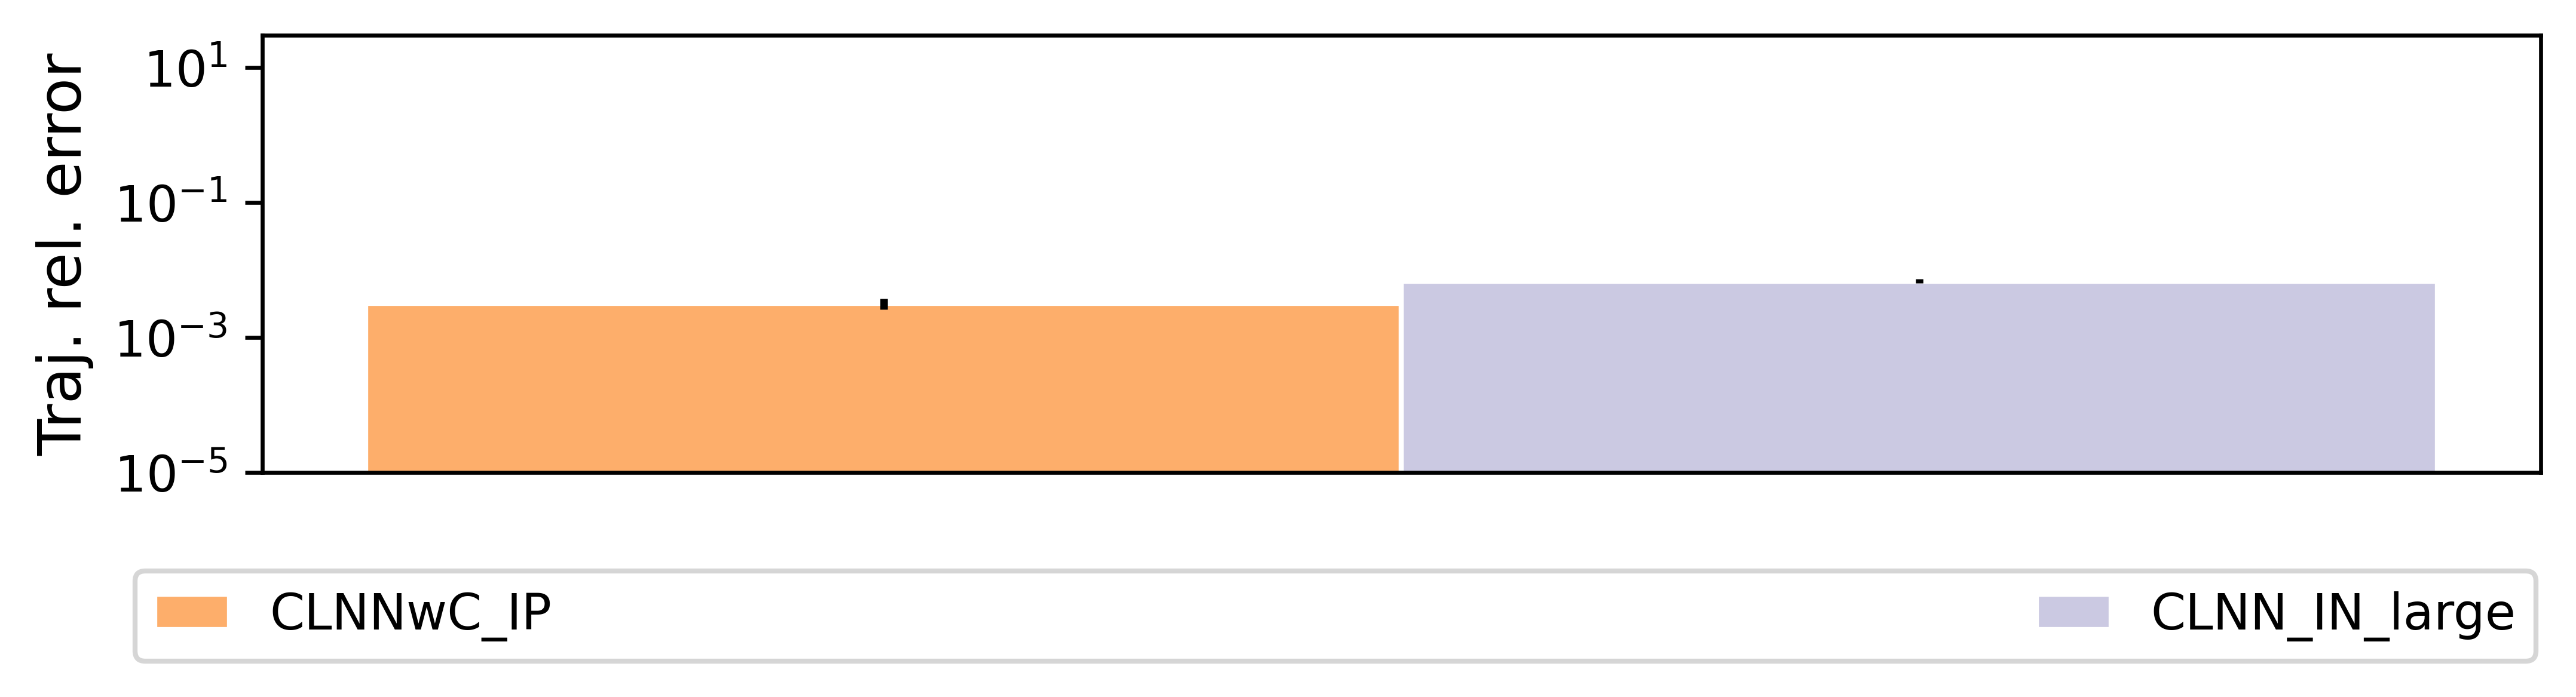

In [27]:
fig, ax = plt.subplots(figsize=(8.2, 2.0), dpi=DPI)

barWidth = 0.1
p_x = []
p_x.append(np.arange(len(system_names)))
for i in range(1, len(model_names)):
    p_x.append([x+barWidth for x in p_x[i-1]])

for i in range(len(model_names)):
    plt.bar(p_x[i], b[model_names[i]], yerr=b_err[model_names[i]], width=barWidth, color=c_palette[i], edgecolor='white', label=formal_model_names[i])
plt.yscale('log')
plt.ylim(0.00001, 30)
plt.xticks([r + 3*barWidth for r in range(len(system_names))], short_system_names, fontsize=12)
plt.ylabel('Traj. rel. error', fontsize=12)

# create legend 
fig.subplots_adjust(bottom=0.27)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels=labels, 
           bbox_to_anchor=(0.08, 0., 0.82, 0.), 
           loc="lower center", 
           ncol=len(labels), 
           borderaxespad=0.1, 
           mode="expand", 
           handlelength=1.5,
           fontsize=10)

In [28]:
for i in range(len(model_names)):
    print(formal_model_names[i] + " error" + f": {b[model_names[i]]}")
    print(formal_model_names[i] + " confidence" + f": {b_err[model_names[i]]}")

CLNNwC_IP error: [0.00319751]
CLNNwC_IP confidence: [0.00056874]
CLNN_IN_large error: [0.0068894]
CLNN_IN_large confidence: [0.00050672]
